In [1]:
import pandas as pd
from pathlib import Path
import networkx as nx
from bg_atlasapi import BrainGlobeAtlas
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
from io import StringIO
import igraph as ig
import leidenalg
import random

plt.rcParams['xtick.bottom'] = True  # Show ticks at the bottom of the x-axis
plt.rcParams['xtick.top'] = True     # Show ticks at the top of the x-axis
plt.rcParams['ytick.left'] = True    # Show ticks on the left side of the y-axis
plt.rcParams['ytick.right'] = True   # Show ticks on the right side of the y-axis


plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

def node_indices(G):

    node_strength = {node: sum(weight['weight'] for _, weight in G[node].items()) for node in G.nodes()}
    betweenness = nx.betweenness_centrality(G, weight='weight')
    eigenvector = nx.eigenvector_centrality_numpy(G, weight='weight')
    closeness = nx.closeness_centrality(G, distance='weight')
    in_degree = dict(G.in_degree(weight='weight'))
    out_degree = dict(G.out_degree(weight='weight'))
    pagerank = nx.pagerank(G, weight='weight')
    clustering = nx.clustering(G, weight='weight')
    hubs, authorities = nx.hits(G, max_iter=1000, tol=1e-08, nstart=None, normalized=True)
    load_centrality = nx.load_centrality(G, weight='weight')
    katz = nx.katz_centrality_numpy(G, weight='weight')


    results_df = pd.DataFrame({
        'Node Strength': node_strength, # sum of all newtork weights
        'Betweenness Centrality': betweenness, # number of shortest path passing through the node
        'Eigenvector Centrality': eigenvector, # the degree to which a node is connected to other node with high degree
        #'Local Efficiency': local_efficiency_scores,
        'Closeness Centrality': closeness,
        'In-degree': in_degree,
        'Out-degree': out_degree,
        'PageRank': pagerank,
        'Clustering Coefficient': clustering,
        'Hubs Score': hubs, # Hubs estimates the node value based on outgoing links.
        'Authorities Score': authorities, # Authorities estimates the node value based on the incoming links
        'Load Centrality': load_centrality, # similar to betweenness
        'Katz Centrality': katz # similar to eigenvestor and pagerank
    })

    return results_df


In [2]:
url = "http://download.alleninstitute.org/publications/A_high_resolution_data-driven_model_of_the_mouse_connectome/normalized_connection_density.csv"
response = requests.get(url)
conn = pd.read_csv(StringIO(response.text), sep=',', header=[0, 1], index_col=0)


In [5]:
observer = pd.read_excel('Data/areas_observer_density.xlsx')
observer = observer[~observer['acronym'].isin(['LSS', 'SNl', 'InCo', 'NC', 'PIN', 'REth','AHA','PSCH','AD','AV'])]
observer.sort_values(by='order',inplace=True)

demonstrator = pd.read_excel('Data/areas_demonstrator_density.xlsx')
demonstrator = demonstrator[~demonstrator['acronym'].isin(['LSS', 'SNl', 'InCo', 'NC', 'PIN', 'REth','AHA','PSCH', 'III','AD','AV'])]
demonstrator = demonstrator.sort_values(by='order').reset_index(drop=True)

observer['observer_only']=~observer['acronym'].isin(demonstrator['acronym'])

observer_conn_raw = conn['ipsi'].loc[observer['acronym'].values,observer['acronym'].values]
np.fill_diagonal(observer_conn_raw.values, np.nan)

demonstrator_conn_raw = conn['ipsi'].loc[demonstrator['acronym'].values,demonstrator['acronym'].values]
np.fill_diagonal(demonstrator_conn_raw.values, np.nan)

observer_only_conn_raw = conn['ipsi'].loc[observer[observer['observer_only']]['acronym'].values,observer[observer['observer_only']]['acronym'].values]
np.fill_diagonal(observer_only_conn_raw.values, np.nan)


acro2col = {row['acronym']:row['struct_color'] for i,row in observer.iterrows()}
acro2name = {row['acronym']:row['name'] for i,row in observer.iterrows()}
acro2struct = {row['acronym']:row['structure'] for i,row in observer.iterrows()}



## Fig. 5 A

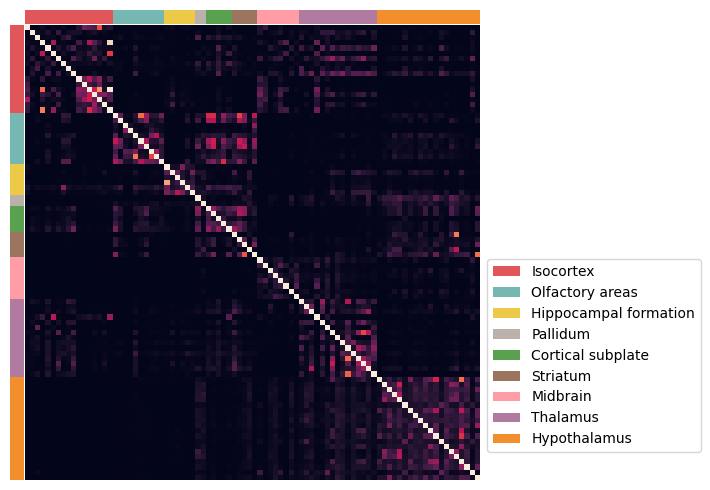

In [6]:
# Observer connectome
connectome = observer_conn_raw.copy()
np.fill_diagonal(connectome.values, connectome.max().max())
cm = sns.clustermap(
    connectome,row_cluster=False, col_cluster=False, col_colors=observer['struct_color'].values,row_colors=observer['struct_color'].values, cbar_pos=None, cbar_kws=None,dendrogram_ratio=(0,0),figsize=(5,5),
    yticklabels=False, xticklabels=False
)

from matplotlib.patches import Patch
maps = list()
cols = observer[['structure','struct_color']].drop_duplicates()
for i,row in cols.iterrows():
    maps.append( Patch(facecolor=row['struct_color'], label=row['structure']) )

plt.legend(handles=maps,bbox_to_anchor=(1.5, 0.5))


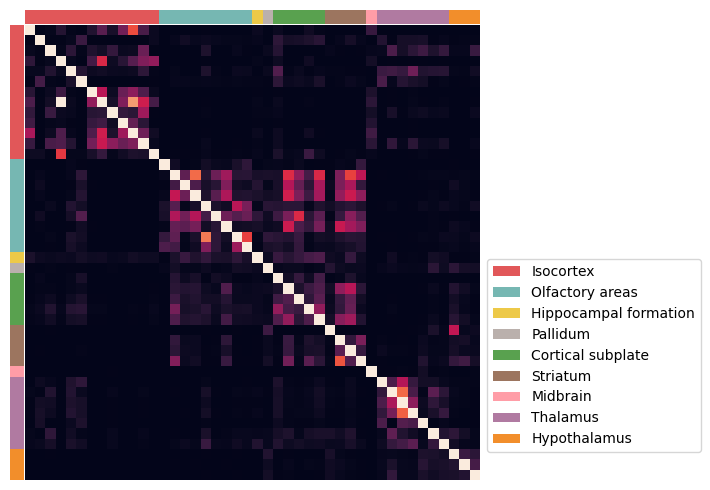

In [7]:
# Demonstrator connectome
connectome = demonstrator_conn_raw.copy()
np.fill_diagonal(connectome.values, connectome.max().max())
cm = sns.clustermap(
    connectome,row_cluster=False, col_cluster=False, col_colors=demonstrator['struct_color'].values,row_colors=demonstrator['struct_color'].values, cbar_pos=None, cbar_kws=None,dendrogram_ratio=(0,0),figsize=(5,5),
    yticklabels=False, xticklabels=False
)

from matplotlib.patches import Patch
maps = list()
cols = demonstrator[['structure','struct_color']].drop_duplicates()
for i,row in cols.iterrows():
    maps.append( Patch(facecolor=row['struct_color'], label=row['structure']) )

plt.legend(handles=maps,bbox_to_anchor=(1.5, 0.5))

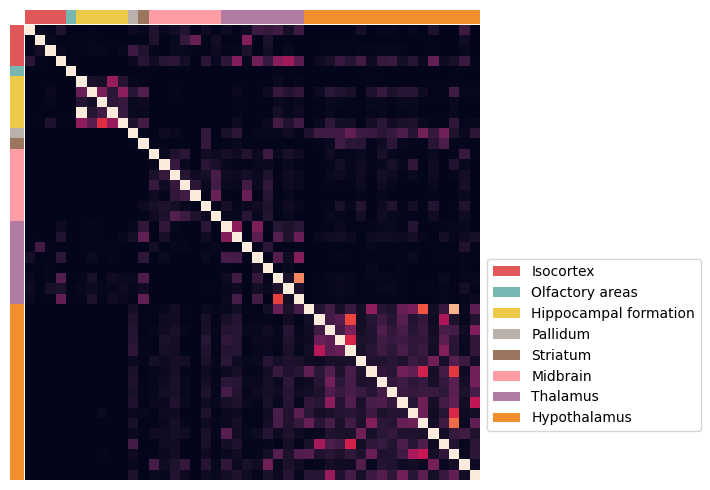

In [8]:
# Observer Only connectome
connectome = observer_only_conn_raw.copy()
np.fill_diagonal(connectome.values, connectome.max().max())
cm = sns.clustermap(
    connectome,row_cluster=False, col_cluster=False, col_colors=observer[observer['observer_only']]['struct_color'].values,row_colors=observer[observer['observer_only']]['struct_color'].values, cbar_pos=None, cbar_kws=None,dendrogram_ratio=(0,0),figsize=(5,5),
    yticklabels=False, xticklabels=False
)

from matplotlib.patches import Patch
maps = list()
cols = observer[observer['observer_only']][['structure','struct_color']].drop_duplicates()
for i,row in cols.iterrows():
    maps.append( Patch(facecolor=row['struct_color'], label=row['structure']) )

plt.legend(handles=maps,bbox_to_anchor=(1.5, 0.5))

# Fig. 5 B

In [9]:

iG = ig.Graph(directed=True)

iG.add_vertices(len(observer_conn_raw.index))
iG.vs['name'] = list(observer_conn_raw.index)

edges = list()
weight = list()
for n,i in enumerate(observer_conn_raw.index):
    for j in range(n):
        if (i!=j):
            if  (n,j) not in edges:
                edges.append((n,j))
                weight.append(observer_conn_raw.loc[i,observer_conn_raw.index[j]])
                edges.append((j,n))
                weight.append(observer_conn_raw.loc[observer_conn_raw.index[j],i])

iG.add_edges(edges)
iG.es['weight'] = weight

In [10]:


# Perform community detection using the Leiden algorithm
partition = leidenalg.find_partition(iG, leidenalg.ModularityVertexPartition, weights='weight', n_iterations=-1, seed=42)

# Print the result
print("Number of communities:", len(partition))
print("Membership of each node:", partition.membership)

# Optional: Print the modularity of the partition
print("Quality of the detected communities:", partition.quality())

Number of communities: 5
Membership of each node: [2, 3, 1, 2, 3, 2, 3, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 1, 4, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 0, 2, 2, 2, 0, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0]
Quality of the detected communities: 0.41820816533992017


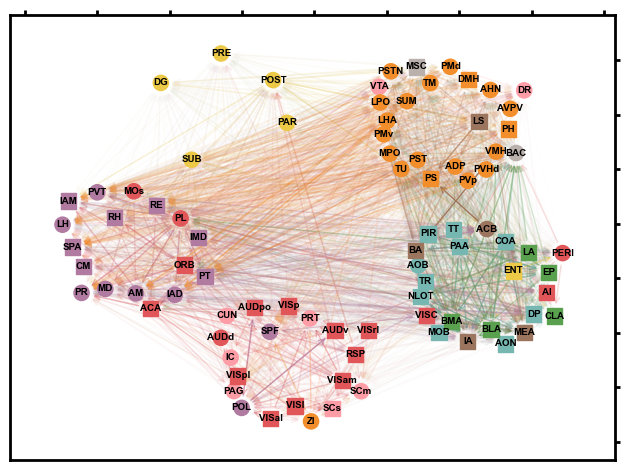

In [11]:
partition_map = {n:p for n,p in zip(iG.vs['name'], partition.membership)}
unique_partitions = np.unique(list(partition_map.values()))
import networkx as nx
import matplotlib.pyplot as plt

#fig, ax = plt.subplots()
# Compute positions for the node clusters as if they were themselves nodes in a
# supergraph using a larger scale factor
supergraph = nx.cycle_graph(len(partition))
superpos = nx.spring_layout(supergraph, scale=2.55, seed=42)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
community_name = dict()

G = nx.DiGraph()
# add nodes
for n,i in enumerate(observer_conn_raw.index):
    G.add_node(i,color=observer.struct_color.iloc[n],structure=observer.structure.iloc[n],name=observer.name.iloc[n])

# add edges
for n,i in enumerate(observer_conn_raw.index):
    for j in range(n):
        if (i!=observer_conn_raw.index[j]):
            if acro2struct[i] != acro2struct[observer_conn_raw.index[j]]:
                G.add_edge(i,observer_conn_raw.index[j],weight=observer_conn_raw.loc[i,observer_conn_raw.index[j]],color=observer.struct_color.iloc[n])
                G.add_edge(observer_conn_raw.index[j],i,weight=observer_conn_raw.loc[observer_conn_raw.index[j],i],color=observer.struct_color.iloc[j])

is_observer = observer['observer_only'].values

# Compute positions for the node clusters as if they were themselves nodes in a supergraph
supergraph = nx.cycle_graph(len(unique_partitions))
superpos = nx.spring_layout(supergraph, scale=2.55, seed=42)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
for center, comm in zip(centers, unique_partitions):
    list_nodes = [node for node in list(G.nodes()) if partition_map[node] == comm]
    subgraph = G.subgraph(list_nodes)
    pos.update(nx.spring_layout(subgraph, center=center, seed=42,scale=1.1, iterations=10))

# Define observer and non-observer nodes
observer_nodes = [n for n, is_obs in zip(G.nodes(), is_observer) if is_obs]
observer_nodes_color = [acro2col[acro] for acro in observer_nodes]
non_observer_nodes = [n for n, is_obs in zip(G.nodes(), is_observer) if not is_obs]
non_observer_nodes_color = [acro2col[acro] for acro in non_observer_nodes]

nx.draw_networkx_nodes(G, pos=pos, nodelist=observer_nodes, node_shape='o', node_color=observer_nodes_color, node_size=120)
nx.draw_networkx_nodes(G, pos=pos, nodelist=non_observer_nodes, node_shape='s', node_color=non_observer_nodes_color, node_size=120)

# Draw edges
norm_weights = np.array([np.abs(i[-1]['weight']) for i in G.edges(data=True)])
nx.draw_networkx_edges(G, pos, edge_color=[i[-1]['color'] for i in G.edges(data=True)], alpha=norm_weights/norm_weights.max(), arrows=True, arrowstyle="->", arrowsize=10)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=7, font_family='arial', font_weight='bold')

font = {"color": "k", "fontweight": "bold", "fontsize": 7}

plt.grid(False)
plt.tight_layout()
#plt.savefig('figures/observer_area_network_partition_shared_not_reference.png',dpi=600)
plt.show()


In [29]:

def rndNetwork(area='BAC'):
    # create a rnd network from random areas of the brain containing 'area'
    area_available = list( filter(lambda x: x not in ['Isocortex','HIP','OLF','PAL',area], conn['ipsi'].index ) )
    random.shuffle(area_available)
    nodes = area_available[0:observer_only_conn_raw.shape[0]]
    nodes[-1] = area

    temp = conn['ipsi'].loc[nodes,nodes]
    np.fill_diagonal(temp.values, 0)
    rG= nx.from_pandas_adjacency(temp, create_using=nx.DiGraph)

    #rG = nx.DiGraph()
    #for i,n in enumerate(nodes):
    #    rG.add_node(n,name=n)
    #    for i,r in enumerate(nodes[i+1:]):
    #        rG.add_edge(n,r,weight=conn['ipsi'].loc[n,r])
    #        rG.add_edge(r,n,weight=conn['ipsi'].loc[r,n])

    return rG

def bootstrapNetwork(area,iter =  1000):
    rnd_hubs = pd.DataFrame(index=range(0,iter),columns=['Hubs Score','Authorities Score'])
    for i in range(iter):
        rG  = rndNetwork(area=area)
        temp_hub = node_hits(rG).loc[area]
        rnd_hubs.loc[i,'Hubs Score'] = temp_hub['Hubs Score']
        rnd_hubs.loc[i,'Authorities Score'] = temp_hub['Authorities Score']
    return rnd_hubs.infer_objects()


def bootstrap_pval(score_real,scores_distribution):

    from scipy import stats
    mean_score = np.mean(scores_distribution)
    std_score = np.std(scores_distribution)

    # Calculate Z-score for your node's hub score
    z_score = (score_real - mean_score) / std_score

    # Calculate p-value from the Z-score (one-tailed test)
    p_value = stats.norm.sf(abs(z_score)) #* 2

    return p_value, z_score

def bootstrap_pval_non_param(score_real,scores_distribution):
    greater_equal_count = np.sum(scores_distribution >= score_real)
    p_value_empirical = greater_equal_count / scores_distribution.shape[0]
    return p_value_empirical

def node_hits(G):
    hubs, authorities = nx.hits(G, max_iter=1000, tol=1e-08, nstart=None, normalized=True)
    results_df = pd.DataFrame({'Hubs Score': hubs, # Hubs estimates the node value based on outgoing links.
                               'Authorities Score': authorities, # Authorities estimates the node value based on the incoming links
                               })
    return results_df


In [30]:
G = nx.DiGraph()
# add nodes
observer_only = observer[observer['observer_only']].set_index('acronym')
observer_only_conn_raw = observer_conn_raw.loc[observer_only.index,observer_only.index]
for n,i in enumerate(observer_only.index):
    G.add_node(i,color=observer_only.struct_color.iloc[n],structure=observer_only.structure.iloc[n],name=observer_only.index[n])

# add edges
for n,i in enumerate(observer_only.index):
    for j in range(n):
        if (i!=observer_only.index[j]):
            if acro2struct[i] != acro2struct[observer_only.index[j]]:  # To different structure
                G.add_edge(i,observer_only_conn_raw.index[j],weight=observer_only_conn_raw.loc[i,observer_only_conn_raw.index[j]],color=observer_only.struct_color.iloc[n])
                G.add_edge(observer_only_conn_raw.index[j],i,weight=observer_only_conn_raw.loc[observer_only_conn_raw.index[j],i],color=observer_only.struct_color.iloc[j])

In [31]:

score_observed = node_hits(G)
stats = pd.DataFrame(index=G.nodes,columns=['Authorities_p_value','Authorities_z_score','Hubs_p_value','Hubs_z_score'])
for i,area in enumerate(G.nodes):
    print(i,area,end=' ')
    rnd_scores = bootstrapNetwork(area=area,iter = 1000)
    stats.loc[area,'Authorities_p_value'],stats.loc[area,'Authorities_z_score'] =  bootstrap_pval(score_observed.loc[area,'Authorities Score'],rnd_scores['Authorities Score'])
    stats.loc[area,'Hubs_p_value'],stats.loc[area,'Hubs_z_score'] =  bootstrap_pval(score_observed.loc[area,'Hubs Score'],rnd_scores['Hubs Score'])
    print(f"{stats.loc[area,'Hubs_p_value']:.4f},{stats.loc[area,'Hubs_z_score']:.4f}")



0 MOs 0.0386,1.7674
1 AUDd 0.2887,-0.5573
2 PERI 0.4996,0.0009
3 PL 0.0000,3.9361
4 AOB 0.4366,-0.1596
5 PAR 0.4923,0.0194
6 POST 0.2365,0.7176
7 DG 0.4046,-0.2415
8 PRE 0.4333,0.1680
9 SUB 0.2364,0.7181
10 BAC 0.0731,1.4528
11 ACB 0.1680,0.9619
12 PRT 0.4141,0.2170
13 DR 0.4510,-0.1231
14 PAG 0.2597,0.6444
15 SCm 0.4519,-0.1207
16 IC 0.3481,-0.3904
17 VTA 0.2631,0.6338
18 CUN 0.3956,0.2647
19 LH 0.4160,-0.2121
20 PVT 0.4866,0.0337
21 POL 0.2425,-0.6984
22 MD 0.3117,-0.4910
23 SPF 0.2834,-0.5729
24 AM 0.3636,-0.3488
25 PR 0.3481,-0.3904
26 IAD 0.3744,-0.3202
27 PVp 0.4490,0.1283
28 AVPV 0.3588,-0.3617
29 AHN 0.4867,0.0334
30 LPO 0.4662,0.0847
31 MPO 0.4619,-0.0957
32 PSTN 0.3960,0.2638
33 TM 0.4487,0.1289
34 PVHd 0.3219,0.4625
35 LHA 0.3047,0.5108
36 TU 0.4575,-0.1067
37 SUM 0.1887,0.8828
38 PMv 0.4309,0.1742
39 PST 0.4775,-0.0565
40 ADP 0.4316,-0.1724
41 PMd 0.2532,0.6645
42 ZI 0.3008,0.5221
43 VMH 0.4719,-0.0704


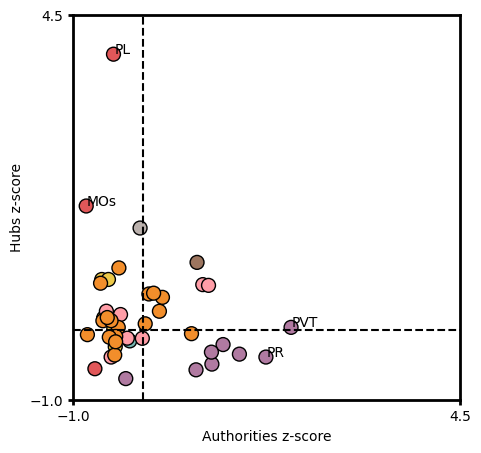

In [46]:
fig,ax = plt.subplots(figsize=(5,5))
ax.axhline(0, color='black',linestyle='--')
ax.axvline(0, color='black',linestyle='--')
ax.scatter(temp['Authorities_z_score'],temp['Hubs_z_score'],edgecolor='k',s=100, facecolor=temp['color'])
ax.set_xlim([-1,4.5])
ax.set_ylim([-1,4.5])
ax.set_xticks([-1,4.5])
ax.set_yticks([-1,4.5])
ax.grid(False)
for i,row in temp.iterrows():
    if (row['Authorities_p_value']<0.05) | (row['Hubs_p_value']<0.05):
        ax.text(row['Authorities_z_score']+0.01,row['Hubs_z_score']+0.01,row['acro'])

ax.set_xlabel('Authorities z-score')
ax.set_ylabel('Hubs z-score')
ax.tick_params(axis='both', which='both',bottom=True, top=False, left=True, right=False)
#stats.to_excel('hits_stats.xlsx')
#plt.savefig('hits_graph.png',dpi=600)
